In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
import numpy as np
from scipy.signal import find_peaks
from tqdm import tqdm
from obspy import read, UTCDateTime
from obspy.signal import konnoohmachismoothing
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings("ignore")

## Functions

In [3]:
def calc_fft(data,npts,sr):
	Fdat = np.fft.rfft(data)
	freq = np.fft.rfftfreq(npts, d=1./sr)
	return 2.0/sr * np.abs(Fdat), freq

def select_station(st,station):
    return st.select(station=station).sort()

def get_median(i_mat):
    return np.nanmedian(i_mat,axis=0)

def smooth(i_fft,bandwidth=160,count=1):
    return konnoohmachismoothing.konno_ohmachi_smoothing(i_fft,freqs, bandwidth=bandwidth, count=count)

def peaks(i_fft,freqs,ax,distance=10):
    peaks, _ = find_peaks(i_fft, distance=distance)
    for peak in peaks:
        if freqs[peak] >= 0.3 and freqs[peak] <= 3:
            ax.text(freqs[peak], i_fft[peak],s=round(freqs[peak],2),size=8)
    return ax
def add_legend(ax,colors):
    custom_lines = [Line2D([0], [0], color=colors['E'], lw=5),
					Line2D([0], [0], color=colors['N'], lw=5),
					Line2D([0], [0], color=colors['Z'], lw=5)]
    pos = ax.get_position()
    ax.legend(custom_lines, ['EW', 'NS', 'Vertical'],loc='upper left',ncol=3,fontsize=12)
    return ax

# Building Information

![Bologna Building](Building.png)

In [4]:
stations = ['RE008', 'RE001', 'RE002', 'RE003', 'RE004', 'RE005', 'RE006']

In [5]:
results = {key: {'Z':[],'N':[],'E':[]} for key in stations}

# Read Data

In [6]:
starttime = UTCDateTime(2023,11,12,0,0,0)
timedelta=60
h = 1*timedelta
endtime = starttime+(h*timedelta)
total_len = endtime - starttime

In [7]:
st = read('Data/Noise/*',format='MSEED',starttime=starttime,endtime=endtime)
st.sort()

24 Trace(s) in Stream:

LK.RE001..EHE | 2023-11-12T00:00:00.000000Z - 2023-11-12T01:00:00.000000Z | 250.0 Hz, 900001 samples
...
(22 other traces)
...
LK.RE008..EHZ | 2023-11-12T00:00:00.000000Z - 2023-11-12T01:00:00.000000Z | 250.0 Hz, 900001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

# FFT Calculation

In [8]:
for station in tqdm(stations):
    st_sta = select_station(st,station)
    minlon = np.arange(0,total_len,timedelta,dtype=np.int16)
    for k, tr in enumerate(st_sta):
        start_time = starttime
        amps_all = []
        for minute in minlon:
            end_time = start_time + timedelta
            tr_trim = tr.copy()
            tr_trim = tr_trim.trim(start_time,end_time)
            start_time = start_time + timedelta
            amps, freqs = calc_fft(tr_trim.data,tr_trim.stats.npts,tr.stats.sampling_rate)
            amps_all.append(amps)
        results[station][tr.stats.channel[-1]] = get_median(np.array(amps_all))

100%|█████████████████████████████████████████████| 7/7 [00:01<00:00,  4.35it/s]


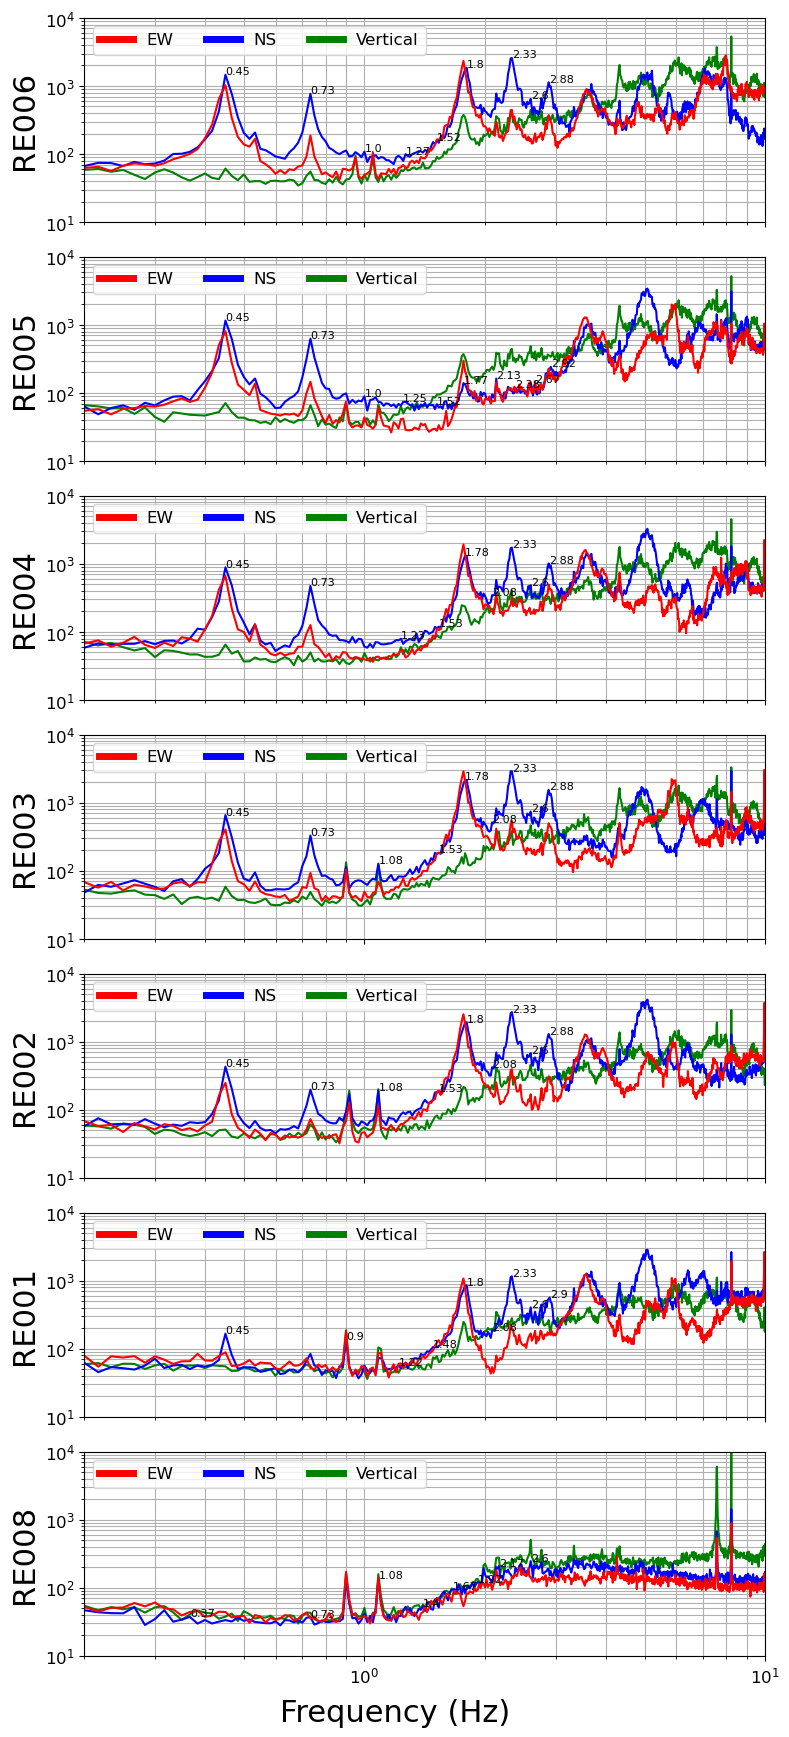

In [9]:
fig, axs = plt.subplots(nrows=len(stations),ncols=1,dpi=100,figsize=(800/100,len(stations)*250/100),sharey=True,sharex=True)
axs[0].set_xlim([0.2,10])
axs[0].set_ylim([10**1,10**4])
colors = {'E':'red','N':'blue','Z':'green'}
for i, station in enumerate(stations[::-1]):
    for channel in results[station].keys():
        values = results[station][channel]
        axs[i].loglog(freqs,values,c=colors[channel])
        axs[i].set_ylabel(station, fontsize=22)
        axs[i].grid('on','both')
        axs[i].tick_params(axis='both', which='both', labelsize=12)
        # Add Peak Values
        if channel == 'N':
            axs[i] = peaks(values,freqs,axs[i],distance=15)
    axs[i] = add_legend(axs[i],colors)
fig.supxlabel('Frequency (Hz)', fontsize=22)
plt.tight_layout()
plt.savefig('Figures/noise.png')

# Spectral Ratio

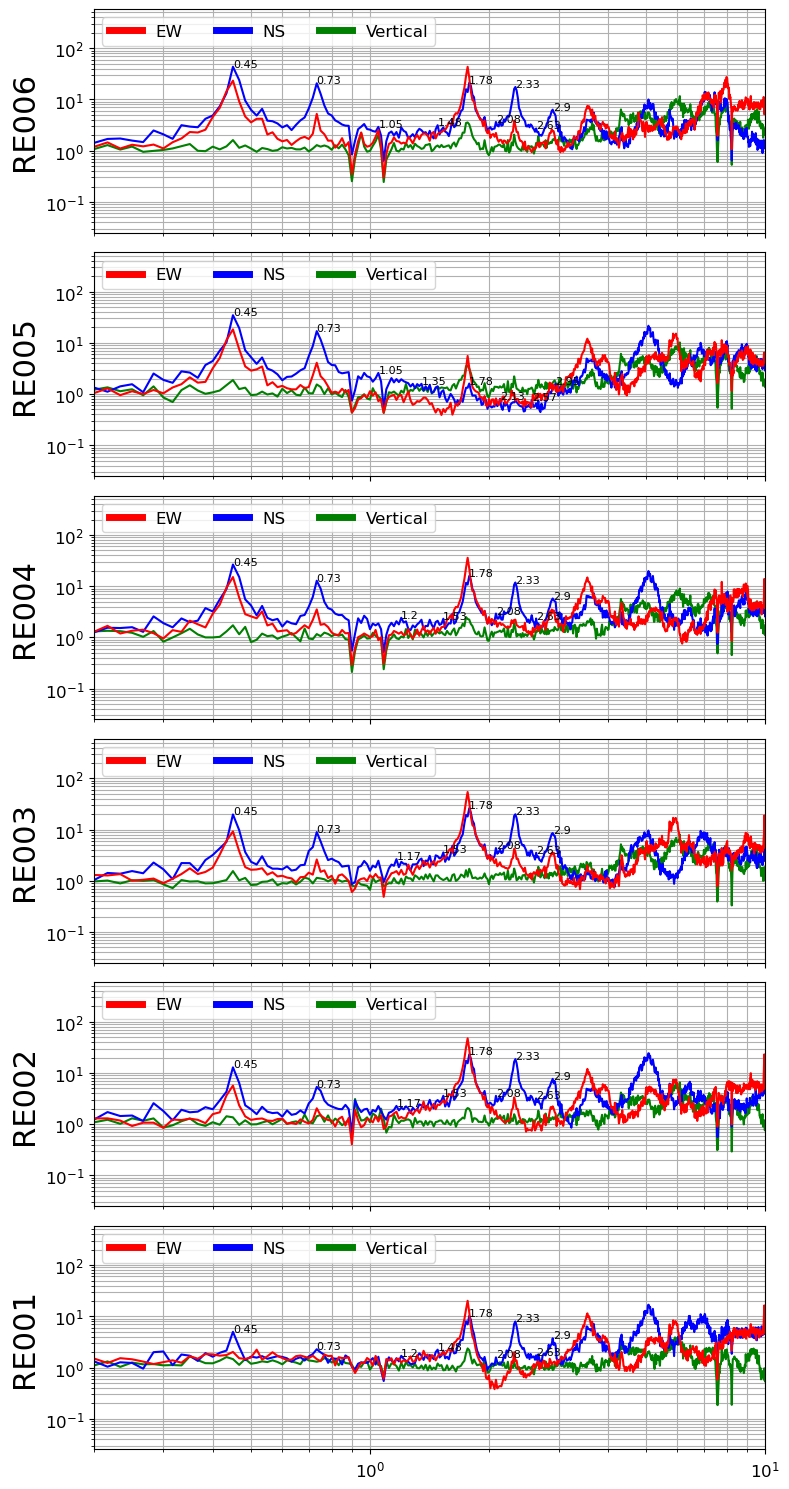

In [10]:
fig2, axs = plt.subplots(nrows=len(stations)-1,ncols=1,dpi=100,figsize=(800/100,(len(stations)-1)*(250/100)),sharey=True,sharex=True)
axs[0].set_xlim([0.2,10])
colors = {'E':'red','N':'blue','Z':'green'}
ref = 'RE008'#stations[0]
spec_stations = stations.copy()
spec_stations.remove(ref)
for i, station in enumerate(spec_stations[::-1]):
    for channel in results[station].keys():
        ref_values = results[ref][channel]
        values = results[station][channel]
        ratio = values/ref_values #smooth(values/ref_values,360)
        axs[i].loglog(freqs,ratio,c=colors[channel])
        axs[i].set_ylabel(station, fontsize=22)
        axs[i].grid('on','both')
        axs[i].tick_params(axis='both', which='both', labelsize=12)
        # Add Peak Values
        if channel == 'N':
            axs[i] = peaks(ratio,freqs,axs[i],distance=15)
    axs[i] = add_legend(axs[i],colors)
fig.supxlabel('Frequency (Hz)', fontsize=22)
plt.tight_layout()
plt.savefig('Figures/noise_spectral_ratio.png')